In [1]:
!pip install bitsandbytes>=0.41.3
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets
!pip uninstall torch torchdata -y
!pip install torch==1.13.1
!pip install torchdata==0.5.1
!pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet
!pip install bert-score
!pip install ludwig
!pip install nlpaug

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [2]:
#bitsandbytes --version

In [3]:
import os
import gc

from google.colab import data_table

import numpy as np
import pandas as pd

import torch
from torch import Tensor

import datasets
from datasets import Dataset, DatasetDict

import yaml
from ludwig.api import LudwigModel, TrainingResults


In [4]:
#from accelerate import FullyShardedDataParallelPlugin, Accelerator
#from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

#fsdp_plugin = FullyShardedDataParallelPlugin(
#    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
#    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
#)

#accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Output.csv to Output.csv


In [6]:
import pandas as pd

file_name = "Output.csv"
try:
    # Prova a leggere il file con il delimitatore corretto
    df = pd.read_csv(file_name, delimiter=',', on_bad_lines='warn')
except pd.errors.ParserError as e:
    print(f"Error parsing CSV file: {e}")

# Visualizza le prime righe del dataset
print(df.head())

                                             DOMANDE  \
0  Ho avuto un breve affanno dopo una passeggiata...   
1  Dovrei essere preoccupato se ho avuto un breve...   
2  Dovrei essere preoccupato per il breve affanno...   
3  Devo preoccuparmi se ho avuto un breve affanno...   
4  Devo essere preoccupato se ho avuto un breve a...   

                                            RISPOSTE  
0  Un breve affanno dopo una passeggiata può esse...  
1  Un breve affanno dopo una passeggiata potrebbe...  
2  È comprensibile essere preoccupati, ma un brev...  
3  Un breve affanno dopo una passeggiata può esse...  
4  Un breve affanno dopo una passeggiata potrebbe...  


##MIGLIORAMENTO PRE-FINETUNING:
1. Pulizia Avanzata dei Dati:
Rimuovi o correggi i dati rumorosi o anomali nel dataset.
Normalizza i testi, ad esempio, convertendo tutto in minuscolo e rimuovendo i caratteri speciali non necessari.

2. Bilanciamento del Dataset:
Assicurati che il dataset abbia una distribuzione bilanciata di domande e risposte per evitare bias.

3. Augmentazione dei Dati:
Utilizza tecniche di augmentazione come la parafrasi automatica per generare più dati di addestramento.

In [7]:
# Pulizia del dataset
df_cleaned = df.dropna()

In [8]:
from sklearn.utils import resample
import nlpaug.augmenter.word as naw

# Bilanciamento del dataset
min_class_size = df_cleaned['DOMANDE'].value_counts().min()
df_balanced = df_cleaned.groupby('DOMANDE').apply(lambda x: resample(x, replace=False, n_samples=min_class_size)).reset_index(drop=True)

# Augmentazione dei dati
aug = naw.SynonymAug(aug_src='wordnet')

df_balanced['DOMANDE_aug'] = df_balanced['DOMANDE'].apply(lambda x: aug.augment(x))
df_balanced['RISPOSTE_aug'] = df_balanced['RISPOSTE'].apply(lambda x: aug.augment(x))

df_augmented = pd.concat([df_balanced[['DOMANDE', 'RISPOSTE']],
                          df_balanced[['DOMANDE_aug', 'RISPOSTE_aug']].rename(columns={'DOMANDE_aug': 'DOMANDE', 'RISPOSTE_aug': 'RISPOSTE'})])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [9]:
df_augmented['DOMANDE'] = df_augmented['DOMANDE'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
df_augmented['RISPOSTE'] = df_augmented['RISPOSTE'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

In [10]:
#suddivisione del set di dati in un set di addestramento, in uno di test e in uno di validazione
from sklearn.model_selection import train_test_split

#separo le caratteristiche dal target (divido input da output)
df_train, df_temp = train_test_split(df_cleaned, test_size=0.3, random_state=200)
df_test, df_validation = train_test_split(df_temp, test_size=0.1, random_state=200)

In [11]:
# Verifica delle dimensioni
print(f'Train set size: {df_train.shape}')
print(f'Test set size: {df_test.shape}')
print(f'Validation set size: {df_validation.shape}')

Train set size: (438, 2)
Test set size: (169, 2)
Validation set size: (19, 2)


In [12]:
# Aggiungere una colonna per indicare lo split (per indicare quale riga appartiene a quale suddivisione.)
df_train["split"] = np.zeros(df_train.shape[0])
df_test["split"] = np.ones(df_test.shape[0])
df_validation["split"] = np.full(df_validation.shape[0], 2)

df_dataset = pd.concat([df_train, df_test, df_validation])
df_dataset["split"] = df_dataset["split"].astype(int)

# Verifica delle dimensioni complessive
print(df_dataset.shape)

(626, 3)


In [13]:
# Verifica delle dimensioni per ciascuno split
assert df_dataset[df_dataset["split"] == 0].shape[0] == df_train.shape[0]
assert df_dataset[df_dataset["split"] == 1].shape[0] == df_test.shape[0]
assert df_dataset[df_dataset["split"] == 2].shape[0] == df_validation.shape[0]

La media del numero di token nella colonna DOMANDE è: 21
La media del numero di token nella colonna RISPOSTE è: 58


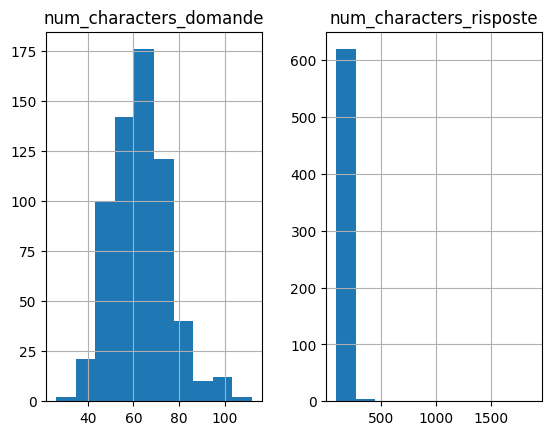

In [14]:
# Calcolare la lunghezza dei caratteri in ciascuna colonna
df_dataset['num_characters_domande'] = df_dataset['DOMANDE'].apply(lambda x: len(str(x)))
df_dataset['num_characters_risposte'] = df_dataset['RISPOSTE'].apply(lambda x: len(str(x)))

# Visualizzare la distribuzione
df_dataset.hist(column=['num_characters_domande', 'num_characters_risposte'])

# Calcolare la media
average_chars_domande = df_dataset['num_characters_domande'].mean()
average_chars_risposte = df_dataset['num_characters_risposte'].mean()

print(f'La media del numero di token nella colonna DOMANDE è: {(average_chars_domande / 3):.0f}')
print(f'La media del numero di token nella colonna RISPOSTE è: {(average_chars_risposte / 3):.0f}')

##Cos'è la Regolarizzazione?
La regolarizzazione è una tecnica utilizzata durante l'addestramento dei modelli di machine learning per prevenire l'overfitting. L'overfitting si verifica quando un modello impara troppo bene i dettagli e il rumore nel dataset di addestramento, perdendo la capacità di generalizzare su nuovi dati. La regolarizzazione aggiunge una penalità per la complessità del modello, aiutando a mantenere il modello più semplice e a migliorare la sua capacità di generalizzare.

**Dropout:**

Dropout è una tecnica di regolarizzazione specificamente utilizzata nelle reti neurali. Durante l'addestramento, il Dropout spegne (esclude) casualmente una frazione di neuroni nel modello a ogni iterazione. Questo impedisce ai neuroni di diventare troppo dipendenti dagli altri neuroni, migliorando la capacità di generalizzazione del modello. Durante l'inferenza (valutazione o previsione), tutti i neuroni sono attivi e i pesi dei neuroni sono scalati per tenere conto del Dropout.

In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Percorso alla cartella del modello salvato
model_path: str = "BioMistral/BioMistral-7B"

# Carica il tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    model_max_length=512,
    trust_remote_code=True,
    padding_side="left",
    add_eos_token=True)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_in_8bit=False,
    llm_int8_threshold=6.0,
    llm_int8_has_fp16_weight=False,
    bnb_4bit_compute_dtype="float16",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)


model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.float16,
    offload_folder="offload", # Offload di parti del modello sulla CPU
    trust_remote_code=True,
    low_cpu_mem_usage=True,
   quantization_config=bnb_config
)


tokenizer_config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/567 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.5G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [16]:
# Estrazione delle prime 10 domande dal DataFrame originale
eval_df = df_test[['DOMANDE', 'RISPOSTE']].head(3)
# Estrai le risposte di riferimento
reference_responses = eval_df['RISPOSTE'].tolist()

In [17]:
#Funzione per assicurarsi che le frasi termino con u punto
def ensure_ending_with_period(response):
    response = response.strip()
    if not response.endswith('.'):
       response += '.'
    return response

In [18]:
prompt_template: str = """
#Genera una risposta per la seguente domanda, come se fossi un esperto cardiologo.
#Le risposte devono essere empatiche, di senso compiuto e LE FRASI DEVONO ESSERE LUNGHE MASSIMO 60 TOKEN E TERMINARE CON UN PUNTO.

### Domanda: {DOMANDE}

### Risposta:
"""

In [19]:
from transformers import pipeline

# Funzione per generare risposte e calcolare BERTScore
def generate_responses_pre_finetuning(model, tokenizer, eval_df):
  #PROVO CON LA PIPELINE DI GENERAZIONE TESTO (Creo la pipeline di generazione)
  response_generator = pipeline(
      task="text-generation",
      model=model,
      tokenizer=tokenizer,
      torch_dtype=torch.float16,
      device_map="auto"
  )

  # Genera e stampa la risposta per le prime 10 domande
  generated_responses = []
  for index, row in eval_df.iterrows():
    domande_test = row['DOMANDE']
    print(f'Generating response for question {index + 1}/{len(eval_df)}: {domande_test}')
    test_prompt = prompt_template.format(DOMANDE=domande_test)
    try:
      responses = response_generator(
          text_inputs=test_prompt,
          do_sample=True,
          top_k=50,
          num_return_sequences=1,
          eos_token_id=tokenizer.eos_token_id,
          max_length=512,
          truncation=True,
          #return_text=True
      )
      print(f'Pipeline output for question {index + 1}: {responses}')
      # Estrai e stampa la risposta generata
      generated_response = responses[0]['generated_text']
      generated_response = ensure_ending_with_period(generated_response)
      generated_responses.append(generated_response)
      print(f'\n[DOMANDA]: {domande_test}\n[GENERATED_TEXT] MODEL_PREDICTION:\n{generated_response}\n')
    except Exception as e:
      print(f"Error generating response for question {index + 1}: {e}")
    print(f"Generated {len(generated_responses)} responses out of {len(eval_df)} expected.")
  return generated_responses
  # Calcola BERTScore
#  P, R, F1 = score(generated_responses, reference_responses, lang="it", verbose=True)
#  return P.mean().item(), R.mean().item(), F1.mean().item()"""

In [20]:
# VALUTAZIONE TRAMITE BERT SCORE
# Valutazione del modello pre-fine-tuning
#print("Valutazione pre-fine-tuning del modello:")
#P_pre, R_pre, F1_pre = generate_and_evaluate(model, tokenizer)
#print(f"Pre-fine-tuning BERTScore - Precision: {P_pre}, Recall: {R_pre}, F1: {F1_pre}")

In [21]:
# Genera le risposte con il modello pre-addestrato
print("Generating responses with the pre-fine-tuning model...")
generated_responses_pre = generate_responses_pre_finetuning(model, tokenizer, eval_df)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Generating responses with the pre-fine-tuning model...
Generating response for question 543/3: Quali sono le informazioni sui controlli per l'ipertensione?


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Pipeline output for question 543: [{'generated_text': "\n#Genera una risposta per la seguente domanda, come se fossi un esperto cardiologo.\n#Le risposte devono essere empatiche, di senso compiuto e LE FRASI DEVONO ESSERE LUNGHE MASSIMO 60 TOKEN E TERMINARE CON UN PUNTO.\n\n### Domanda: Quali sono le informazioni sui controlli per l'ipertensione?\n\n### Risposta:\nCome è possibile notare il tuo paziente ha un discreto apastico, è stato una chiamata alla polisetia nel frattempo. Come preghi non capiscilmi bene il paziente mentre cerca di riferirsi al tipo di medicazione presa. Come stavo dicendo nel caso e il paziente è interessato. Come sono le possibilità di iniziai il trat tamento con altro diossidato di clorida o un antagonista dei Minorei. Come poi consegna il frangio con l'attenzione e le sicurizzazione del polso per cercare di riprendere il dialogo. Come poi si può andare perciò come chiamata di rispetto, ma l'atmosfera è ancora non vespertina e il paziente è ancora percoglievole

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Pipeline output for question 222: [{'generated_text': "\n#Genera una risposta per la seguente domanda, come se fossi un esperto cardiologo.\n#Le risposte devono essere empatiche, di senso compiuto e LE FRASI DEVONO ESSERE LUNGHE MASSIMO 60 TOKEN E TERMINARE CON UN PUNTO.\n\n### Domanda: Quante volte dovrei misurare la mia pressione sanguigna?\n\n### Risposta:\nDentro al mio app, vedrete ci sono diverse possibilità per come misurare la PAS. Tale procedimento cambia da persona a persona perché è influenzato da molti fattori. Le regole più comuni per quantificare la PAS sono le seguenti: misurare PAS prima delle ore e dopo le ore in sedere con gli occhi chiusi, il corpo appesantiato. E non vorrete aver paura o preocupato durante la misura: se avete bisogno di sfocare, puoi usare un contatore appeso ai piedi. In questo modo la pressione si può essere misurata con un misurastore automatico. È importante saree seduti per quantificare la PAS, come se doi fosse sentire in spera che si può esse

In [22]:
# Verifica che il numero di risposte generate corrisponda al numero di risposte di riferimento
print(f"Expected {len(reference_responses)} responses. Generated {len(generated_responses_pre)} responses.")
# Verifica che il numero di risposte generate corrisponda al numero di risposte di riferimento
assert len(generated_responses_pre) == len(reference_responses), "Il numero di risposte generate non corrisponde al numero di risposte di riferimento."

Expected 3 responses. Generated 3 responses.


In [23]:
from bert_score import score
# Calcola BERTScore per il modello pre-addestrato
print("Evaluating BERTScore for the pre-fine-tuning model...")
P_pre, R_pre, F1_pre = score(generated_responses_pre, reference_responses, lang="it", verbose=True)
print(f"Pre-fine-tuning BERTScore - Precision: {P_pre.mean().item()}, Recall: {R_pre.mean().item()}, F1: {F1_pre.mean().item()}")


Evaluating BERTScore for the pre-fine-tuning model...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.46 seconds, 6.58 sentences/sec
Pre-fine-tuning BERTScore - Precision: 0.571518063545227, Recall: 0.6776569485664368, F1: 0.6200514435768127


In [45]:
# Converti i tensori PyTorch in array NumPy, se necessario
if isinstance(P_pre, torch.Tensor):
    P_pre = P_pre.numpy()
if isinstance(R_pre, torch.Tensor):
    R_pre = R_pre.numpy()
if isinstance(F1_pre, torch.Tensor):
    F1_pre = F1_pre.numpy()

# Stampa i punteggi medi
print(f'Mean Precision: {np.mean(P_pre):.4f}')
print(f'Mean Recall: {np.mean(R_pre):.4f}')
print(f'Mean F1: {np.mean(F1_pre):.4f}')

Mean Precision: 0.5715
Mean Recall: 0.6777
Mean F1: 0.6201


In [24]:
model.gradient_checkpointing_enable()
# Free up memory
torch.cuda.empty_cache()
gc.collect()

93

In [25]:
yaml_config_template = """
model_type: llm
base_model: {model_path}

input_features:
  - name: DOMANDE
    type: text
    preprocessing:
      max_sequence_length: 300
      truncation: true

output_features:
  - name: RISPOSTE
    type: text
    preprocessing:
      max_sequence_length: 300
      truncation: true
    metrics:
      - type: bert_score
        model: bert-base-uncased

prompt:
  template: >-
    Genera una risposta per la seguente domanda, come se fossi un esperto cardiologo.
    Le risposte devono essere empatiche, di senso compiuto e LE FRASI DEVONO TERMINARE CON UN PUNTO e essere lunghe massimo 60 token.
    ### Domanda: {DOMANDE}

    ### Risposta (Deve terminare con un punto e essere di senso compiuto):

generation:
  temperature: 0.7  # Abbassa la temperatura per risposte più coerenti
  max_new_tokens: 60

adapter:
  type: lora

quantization:
  bits: 4

preprocessing:
  split:
    type: fixed

trainer:
  type: finetune
  epochs: 2
  batch_size: 2
  eval_batch_size: 2
  gradient_accumulation_steps: 8  # effective batch size = batch size * gradient_accumulation_steps
  learning_rate: 1.0e-4  # Prova con un learning rate leggermente più basso
  enable_gradient_checkpointing: true
  learning_rate_scheduler:
    decay: cosine
    warmup_fraction: 0.1  # Aumenta il warmup fraction
    reduce_on_plateau: 0
"""

In [26]:
# Sostituisci solo il segnaposto {model_path}
yaml_config = yaml_config_template.replace("{model_path}", model_path)

# Carica la configurazione YAML come dizionario
qlora_fine_tuning_config = yaml.safe_load(yaml_config)


In [27]:
# Inizializza il modello Ludwig con la configurazione aggiornata
model_ludwig = LudwigModel(config=qlora_fine_tuning_config)

In [28]:
# Esegui il fine-tuning del modello con Ludwig
model_ludwig.train(dataset=df_train)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.0470


/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


TrainingResults(train_stats=TrainingStats(training={'RISPOSTE': {'loss': [1.144463300704956, 0.7642276883125305], 'next_token_perplexity': [16800.009765625, 15637.2939453125], 'perplexity': [31992.0703125, 31977.21484375], 'sequence_accuracy': [0.0, 0.0], 'token_accuracy': [9.349289757665247e-05, 0.00028730681515298784]}, 'combined': {'loss': [1.144463300704956, 0.7642276883125305]}}, validation={}, test={}, evaluation_frequency=EvaluationFrequency(frequency=1, period='epoch')), preprocessed_data=PreprocessedDataset(training_set=<ludwig.data.dataset.pandas.PandasDataset object at 0x7e1e840e0d30>, validation_set=None, test_set=None, training_set_metadata={'checksum': 't9X3mweZhtqQ0eKC2DdBgw==', 'DOMANDE': {'idx2str': ['<unk>', '<s>', '</s>', '<0x00>', '<0x01>', '<0x02>', '<0x03>', '<0x04>', '<0x05>', '<0x06>', '<0x07>', '<0x08>', '<0x09>', '<0x0A>', '<0x0B>', '<0x0C>', '<0x0D>', '<0x0E>', '<0x0F>', '<0x10>', '<0x11>', '<0x12>', '<0x13>', '<0x14>', '<0x15>', '<0x16>', '<0x17>', '<0x18>',

In [29]:
#results: TrainingResults = model.train(dataset=df_dataset)

In [33]:
#Lo salvo e lo ricarico per eseguirlo
# Salva il modello
model_ludwig.save("FineTuned_Biomistral_Ludwig")

In [34]:
# Carica il modello salvato
model_loaded = LudwigModel.load("FineTuned_Biomistral_Ludwig")

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [41]:
from bert_score import score

# Funzione per generare risposte e calcolare BERTScore
def generate_responses_post_finetuning(model, eval_df):
    # Ottieni le previsioni dal modello
    predictions_df = model.predict(dataset=eval_df)

    # Se predictions_df è una tupla, ottieni il DataFrame delle previsioni
    if isinstance(predictions_df, tuple):
        predictions_df = predictions_df[0]

    # Verifica se il DataFrame predictions contiene la colonna 'RISPOSTE_response'
    if 'RISPOSTE_response' in predictions_df.columns:
        # Estrai le risposte generate
        generated_responses = predictions_df['RISPOSTE_response'].apply(lambda x: ''.join(x) if isinstance(x, list) else x).tolist()

        for domanda, risposta in zip(eval_df['DOMANDE'], generated_responses):
            print(f'\n[DOMANDA]: {domanda}\n[GENERATED_TEXT] MODEL_PREDICTION:\n{risposta}\n')
        return generated_responses
    else:
        raise ValueError("La colonna 'RISPOSTE_response' non è presente nel DataFrame delle previsioni.")


In [36]:
# Genera le risposte con il modello fine-tunato
print("Generating responses with the post-fine-tuning model...")
generated_responses_post = generate_responses_post_finetuning(model_loaded, eval_df)


Generating responses with the post-fine-tuning model...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/ludwig/data/preprocessing.py:1311: UserWarning: column: 'split' is required by the dataset splitter with params: {'type': 'fixed', 'column': 'split'}, but 'split' is not present in the `dataset_df` with columns: Index(['DOMANDE', 'RISPOSTE'], dtype='object'). This is acceptable during serving setting where dataset splitting is irrelevant. You may see this warning if, for example, the model was trained with a configuration that used a stratified split on the target column, but for live predictions, a value for the target column is not to be provided.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the 


[DOMANDA]: Quali sono le informazioni sui controlli per l'ipertensione?
[GENERATED_TEXT] MODEL_PREDICTION:
Controlla regolarmente la tua pressione arteriosa e segui gli ordini dei tuoi medici per ridurre i rischi di complicazioni, come infarti e ictus.


[DOMANDA]: Quante volte dovrei misurare la mia pressione sanguigna?
[GENERATED_TEXT] MODEL_PREDICTION:
Il consiglio più comune è di misurare la tua pressione sanguigna almeno una volta al giorno, ma è importante trovare il momento più conveniente per te, come prima di pranzo, prima di andare a letto o dopo aver


[DOMANDA]: L'attività fisica costante può abbassare la pressione arteriosa?
[GENERATED_TEXT] MODEL_PREDICTION:
Sì, l'attività fisica regolare può aiutare a ridurre la pressione arteriosa in persone con problemi cardiovascolari.



/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [37]:
from bert_score import score
# Calcola BERTScore per il modello fine-tunato
print("Evaluating BERTScore for the post-fine-tuning model...")
P_post, R_post, F1_post = score(generated_responses_post, reference_responses, lang="it", verbose=True)
print(f"Post-fine-tuning BERTScore - Precision: {P_post.mean().item()}, Recall: {R_post.mean().item()}, F1: {F1_post.mean().item()}")

Evaluating BERTScore for the post-fine-tuning model...
calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.08 seconds, 38.05 sentences/sec
Post-fine-tuning BERTScore - Precision: 0.7633757591247559, Recall: 0.7606126666069031, F1: 0.7609310150146484


In [ ]:
#estrai un campione di 10 righe dal dataframe di addestramento per la valutazione
#df_evaluation: pd.DataFrame = df_train.sample(n=10, random_state=200)

# Ottieni le previsioni e le probabilità dal modello caricato
#predictions_and_probabilities: tuple[pd.DataFrame, pd.DataFrame] = model_loaded.predict(df_evaluation)

Viene creato un campione di dati da valutare (df_evaluation). Il modello fa previsioni su questo campione e il risultato è una tupla che contiene due DataFrame: uno con le previsioni (df_predictions) e uno con le probabilità associate a queste previsioni.

#### PREDICTION

In [40]:
#estrazione del dataframe delle previsioni
#df_predictions: pd.DataFrame = predictions_and_probabilities[0]

NameError: name 'predictions_and_probabilities' is not defined

#####Verifica delle Previsioni

* **RISPOSTE_predictions:** le previsioni fatte dal modello. Aiuta a capire quale risposta il modello ha generato per un dato input. Può essere utile per analizzare il comportamento del modello su diverse domande o input.
* **RISPOSTE_probabilities:** le probabilità associate a ciascuna previsione.
Fornisce un'idea di quanto il modello sia sicuro delle sue risposte. Può essere utile per identificare risposte su cui il modello ha bassa confidenza e che potrebbero richiedere una revisione o un miglioramento del modello.
* **RISPOSTE_response:** la risposta generata dal modello. È la risposta che sarà presentata all'utente finale. È utile per valutare direttamente la qualità delle risposte generate dal modello e confrontarle con le risposte di riferimento.
* **RISPOSTE_probability:** la probabilità complessiva della risposta generata, che può essere un'aggregazione delle probabilità delle singole parole nella risposta. Può essere usata per filtrare risposte con bassa confidenza o per segnalare risposte che potrebbero necessitare di una verifica manuale.

In [ ]:
#df_predictions.columns

####PROBABILITA'

In [ ]:
# Ottieni le probabilità dal secondo elemento della tupla
#df_probabilities: pd.DataFrame = predictions_and_probabilities[1]

#####Verifica delle probabilità



In [ ]:
# Visualizza le colonne del DataFrame delle probabilità
#print(df_probabilities.columns)

In [ ]:
# Analisi delle previsioni
#for index, row in df_predictions.iterrows():
#    prediction = row['RISPOSTE_predictions']
#    probability = df_probabilities.at[index, 'RISPOSTE_probabilities']
#    response = row['RISPOSTE_response']
#    response_probability = row['RISPOSTE_probability']

#    print(f"Prediction: {prediction}")
#    print(f"Probability: {probability}")
#    print(f"Response: {response}")
#    print(f"Response Probability: {response_probability}")

    # Esempio di filtro basato sulla probabilità
#    if response_probability < 0.5:
#        print("Bassa confidenza nella risposta, revisione necessaria.")
#    else:
#        print("Risposta con alta confidenza.")

In [ ]:
# Estrarre le prime 10 domande dal DataFrame originale
#eval_df = df_train[['DOMANDE']].head(10)

In [ ]:
# Preparare un prompt di valutazione come DataFrame per la previsione
#eval_prompt = "Che cos'è l'ipertensione?"

# Creare un DataFrame con le domande
#eval_df = pd.DataFrame([{"DOMANDE": eval_prompt}])

# Previsioni sul prompt
#predictions: list[str] = model.predict(dataset=eval_df) #model_loaded

In [ ]:
#print(predictions)

In [ ]:
# Verifica se predictions è una tupla e ottieni il DataFrame delle previsioni
#if isinstance(predictions, tuple):
#    predictions = predictions[0]


In [ ]:
# Verifica se il DataFrame predictions contiene la colonna 'RISPOSTE_response'
#if isinstance(predictions, pd.DataFrame) and 'RISPOSTE_response' in predictions.columns:
    # Itera e stampa ciascuna previsione
#    for response in predictions['RISPOSTE_response']:
#        response_string = "".join(response)  # Concatena la lista di caratteri in una stringa
#        print(response_string)

In [ ]:
# Estrai le risposte generate (predictions)
#generated_responses = df_predictions['RISPOSTE_response'].apply(lambda x: ''.join(x) if isinstance(x, list) else x).tolist()

# Supponiamo che tu abbia un dataset di valutazione con le risposte di riferimento
# Aggiungi le risposte di riferimento al DataFrame delle predizioni
#df_evaluation['RISPOSTE_RIFERIMENTO'] = df_evaluation['RISPOSTE']

# Estrai le risposte di riferimento
#reference_responses = df_evaluation['RISPOSTE_RIFERIMENTO'].tolist()
#print(reference_responses)

In [ ]:

# Calcola BERTScore
#P, R, F1 = score(generated_responses, reference_responses, lang="it", verbose=True)

# Aggiungi i punteggi BERTScore al DataFrame
#df_predictions['BERTScore_P'] = P_post.tolist()
#df_predictions['BERTScore_R'] = R_post.tolist()
#df_predictions['BERTScore_F1'] = F1_post.tolist()

In [ ]:
#print(df_predictions)

In [38]:
# Converti i tensori PyTorch in array NumPy, se necessario
if isinstance(P_post, torch.Tensor):
    P = P_post.numpy()
if isinstance(R_post, torch.Tensor):
    R = R_post.numpy()
if isinstance(F1_post, torch.Tensor):
    F1 = F1_post.numpy()

# Stampa i punteggi medi
print(f'Mean Precision: {np.mean(P):.4f}')
print(f'Mean Recall: {np.mean(R):.4f}')
print(f'Mean F1: {np.mean(F1):.4f}')

Mean Precision: 0.7634
Mean Recall: 0.7606
Mean F1: 0.7609


In [43]:
# Ottieni le previsioni dal modello
df_pred = model_loaded.predict(dataset=eval_df)

# Se df_pred è una tupla, ottieni il DataFrame delle previsioni
if isinstance(df_pred, tuple):
   df_pred = df_pred[0]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/ludwig/data/preprocessing.py:1311: UserWarning: column: 'split' is required by the dataset splitter with params: {'type': 'fixed', 'column': 'split'}, but 'split' is not present in the `dataset_df` with columns: Index(['DOMANDE', 'RISPOSTE'], dtype='object'). This is acceptable during serving setting where dataset splitting is irrelevant. You may see this warning if, for example, the model was trained with a configuration that used a stratified split on the target column, but for live predictions, a value for the target column is not to be provided.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the 

In [39]:
# Comprimi la directory del modello
!zip -r FineTuned_Biomistral_Ludwig.zip FineTuned_Biomistral_Ludwig

# Scarica il file compresso sul tuo PC
files.download('FineTuned_Biomistral_Ludwig.zip')

  adding: FineTuned_Biomistral_Ludwig/ (stored 0%)
  adding: FineTuned_Biomistral_Ludwig/model_hyperparameters.json (deflated 88%)
  adding: FineTuned_Biomistral_Ludwig/model_weights/ (stored 0%)
  adding: FineTuned_Biomistral_Ludwig/model_weights/adapter_model.safetensors (deflated 7%)
  adding: FineTuned_Biomistral_Ludwig/model_weights/adapter_config.json (deflated 52%)
  adding: FineTuned_Biomistral_Ludwig/model_weights/README.md (deflated 66%)
  adding: FineTuned_Biomistral_Ludwig/training_set_metadata.json (deflated 83%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# Salva i risultati in un nuovo file CSV
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Percorso del file da salvare
file_path = os.path.join(results_dir, 'bertscore_results1.csv')

df_pred.to_csv(file_path, index=False)

import shutil

# Percorso del file zip
zip_file = 'results.zip'

# Comprime la cartella 'results'
shutil.make_archive('results', 'zip', 'results')

print(f"Cartella compressa in: {zip_file}")

# Scarica il file zip
files.download(zip_file)

Cartella compressa in: results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#BERT SCORE

**Precision**: Indica la percentuale di parole generate dal modello che sono rilevanti (ovvero, che appaiono anche nella risposta di riferimento). Un valore più alto indica che le risposte generate contengono molte parole corrette.

**Recall**: Indica la percentuale di parole rilevanti che sono state effettivamente generate dal modello. Un valore più alto indica che il modello riesce a coprire bene il contenuto delle risposte di riferimento.

**F1**: È la media armonica di Precision e Recall. Fornisce una misura complessiva dell'accuratezza del modello bilanciando sia Precision che Recall.

## PROVA1:
Mean Precision: 0.7362
Mean Recall: 0.7124
Mean F1: 0.7235